## Data Loading and Preprocessing
 Load the Iris dataset, separate the species labels, drop unnecessary columns, and standardize the features.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

# Load data
df = pd.read_csv('Iris Dataset.csv')
species_labels = df['Species'].copy()
data = df.drop(['Id', 'Species'], axis=1)

# Standardize the data
def standardize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

X = data.values
X_std = standardize(X)

## Principal Component Analysis
 Perform PCA to reduce the dataset to 3 dimensions and analyze the variance explained by each principal component.


In [2]:
def pca(X, n_components=3):
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    principal_components = eigenvectors[:, :n_components]
    X_pca = np.dot(X, principal_components)
    return X_pca, eigenvalues, principal_components

X_pca, eigenvalues, pcs = pca(X_std)
variance_explained = eigenvalues / np.sum(eigenvalues) * 100

## K-Means Clustering
 Cluster the standardized data into 3 groups and compute centroids and cluster assignments.

In [3]:
def k_means(X, k=3, max_iters=100, n_init=20):
    best_clusters = None
    best_centroids = None
    best_inertia = float('inf')

    for _ in range(n_init):
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for _ in range(max_iters):
            distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
            clusters = np.argmin(distances, axis=0)
            new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
            if np.allclose(centroids, new_centroids, rtol=1e-4):
                break
            centroids = new_centroids
        inertia = sum(np.sum((X[clusters == i] - centroids[i])**2) for i in range(k))
        if inertia < best_inertia:
            best_inertia = inertia
            best_clusters = clusters
            best_centroids = centroids

    return best_clusters, best_centroids

clusters, centroids = k_means(X_std, k=3)

## Cluster Accuracy Evaluation
 Map clusters to actual species using majority voting and compute accuracy.

In [4]:
def map_clusters_to_species(clusters, species_labels):
    cluster_to_species = {}
    for cluster_id in np.unique(clusters):
        species_in_cluster = species_labels[clusters == cluster_id]
        most_common = Counter(species_in_cluster).most_common(1)[0][0]
        cluster_to_species[cluster_id] = most_common
    return cluster_to_species

cluster_map = map_clusters_to_species(clusters, species_labels)
predicted_species = np.array([cluster_map[c] for c in clusters])
accuracy = np.mean(predicted_species == species_labels) * 100


## Confusion matrix

In [5]:
def create_confusion_matrix(true_labels, pred_labels):
    classes = np.unique(true_labels)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    class_to_idx = {cls: i for i, cls in enumerate(classes)}
    for true, pred in zip(true_labels, pred_labels):
        matrix[class_to_idx[true], class_to_idx[pred]] += 1
    return matrix, classes

conf_matrix, classes = create_confusion_matrix(species_labels, predicted_species)


## PCA and Clustering Visualizations
Generate plots to visualize variance explained, PCA projection, clustering, and actual species distribution.

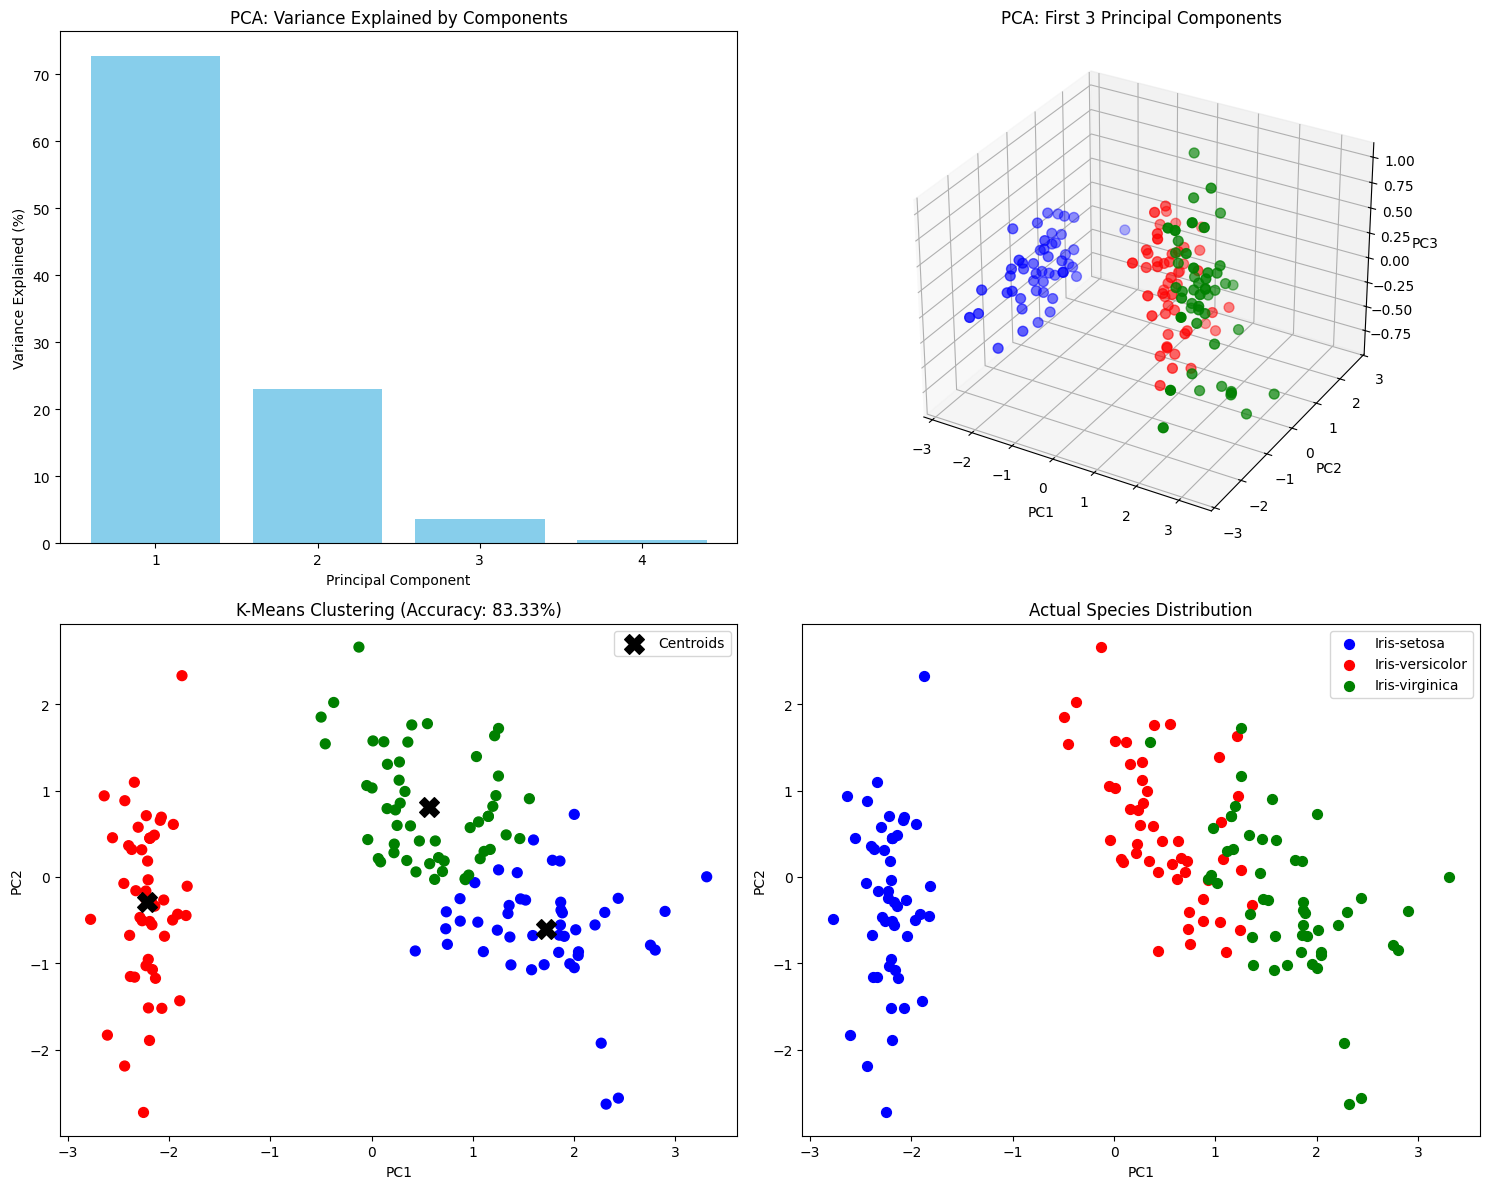

In [6]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.bar(range(1, 5), variance_explained, color='skyblue')
plt.title('PCA: Variance Explained by Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.xticks(range(1, 5))

ax = plt.subplot(222, projection='3d')
species_colors = {
    'Iris-setosa': 'blue',
    'Iris-versicolor': 'red',
    'Iris-virginica': 'green'
}
colors = [species_colors[s] for s in species_labels]
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=colors, s=50)
ax.set_title('PCA: First 3 Principal Components')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.subplot(223)
cluster_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'white'}
colors = [cluster_colors[c] for c in clusters]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=50)
plt.title(f'K-Means Clustering (Accuracy: {accuracy:.2f}%)')
plt.xlabel('PC1')
plt.ylabel('PC2')
centroids_pca = np.dot(centroids, pcs[:, :2])
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='black', label='Centroids')
plt.legend()

plt.subplot(224)
for species in np.unique(species_labels):
    idx = species_labels == species
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=species_colors[species], label=species, s=50)
plt.title('Actual Species Distribution')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

plt.tight_layout()
plt.savefig('iris_analysis.png', dpi=300)
plt.show()

## Confusion Matrix and Summary Report
 Display the confusion matrix and print evaluation metrics and eigenvalue summary.

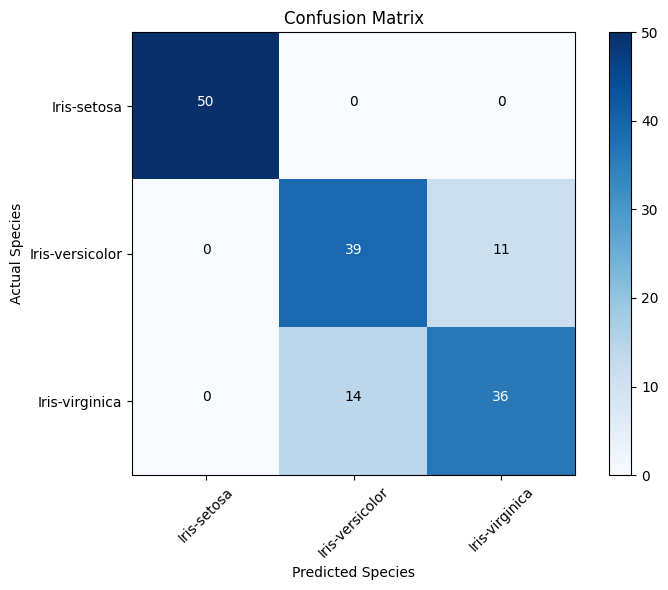

Clustering Accuracy: 83.33%

Eigenvalues and Variance Explained:
PC1: 2.9304 (Variance: 72.77%)
PC2: 0.9274 (Variance: 23.03%)
PC3: 0.1483 (Variance: 3.68%)
PC4: 0.0207 (Variance: 0.52%)

Cluster to Species Mapping:
Cluster 0 → Iris-setosa
Cluster 1 → Iris-versicolor
Cluster 2 → Iris-virginica

Confusion Matrix:
[[50  0  0]
 [ 0 39 11]
 [ 0 14 36]]

GitHub Link https://github.com/Aryan-Kanada/FSM.ML.3


In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', color='white' if conf_matrix[i, j] > thresh else 'black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Species')
plt.ylabel('Actual Species')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

print(f"Clustering Accuracy: {accuracy:.2f}%")
print("\nEigenvalues and Variance Explained:")
for i, val in enumerate(eigenvalues):
    print(f"PC{i+1}: {val:.4f} (Variance: {variance_explained[i]:.2f}%)")

print("\nCluster to Species Mapping:")
for cluster_id, species in cluster_map.items():
    print(f"Cluster {cluster_id} → {species}")

print("\nConfusion Matrix:")
print(conf_matrix)

# GitHub
link = 'https://github.com/Aryan-Kanada/FSM.ML.3'
print("\nGitHub Link", link)
